In [12]:
# ===============================================================
#  Library
# ===============================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

import multiprocessing
NUM_CORES = multiprocessing.cpu_count()

import warnings
#warnings.simplefilter("ignore")

from tqdm.auto import tqdm
import lightgbm as lgb


In [13]:
# ===============================================================
#  CFG
# ===============================================================
class CFG:
    seed = 42
    n_splits = 5
    data_dir = "G:/マイドライブ/signate_MUFJ2023/data/"
    num_boost_round = 10000
    stopping_rounds = 1500
    save_dir = "G:/マイドライブ/signate_MUFJ2023/exp/"

In [14]:
# ===============================================================
#  Utils
# ===============================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
seed_everything(CFG.seed)
    

def get_score(y_true, y_pred):
    """
    評価関数の入力となる検証用データ、及び学習に使用する学習用データの目的変数について、
    1: 不正利用あり, 0: 不正利用なしとします。
    """
    best_score = -np.inf
    j = 0
    for i in tqdm(np.arange(0, 1, 0.001)):
        y_pred_class = [1 if y > i else 0 for y in y_pred]
        score = f1_score(y_true, y_pred_class)
        if best_score < score:
            best_score = score
            best_threshold = i
            j = 0
        else:
            j += 1
        if j > 100:
            break
    return best_score, best_threshold

In [15]:
# ===============================================================
#  Data Loading
# ===============================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")
card = pd.read_csv(CFG.data_dir+"card.csv")
user = pd.read_csv(CFG.data_dir+"user.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)
all_data = pd.merge(all_data, card, on=["user_id", "card_id"], how="left")
all_data = pd.merge(all_data, user, on="user_id", how="left")

In [16]:
# ===============================================================
#  Preprocessing
# ===============================================================
# common part
## amount
all_data["amount"] = all_data["amount"].apply(lambda x:x[1:]).astype(float)


all_data['credit_limit'] = all_data['credit_limit'].apply(lambda x:x[1:]).astype(float)

## per_capita_income_zipcode	
all_data["per_capita_income_zipcode"] = all_data["per_capita_income_zipcode"].apply(lambda x:x[1:]).astype(float)

## yearly_income_person	
all_data["yearly_income_person"] = all_data["yearly_income_person"].apply(lambda x:x[1:]).astype(float)

## total_debt
all_data["total_debt"] = all_data["total_debt"].apply(lambda x:x[1:]).astype(float)

## expires
all_data[["expires_1", "expires_2"]] = all_data["expires"].str.split("/", expand=True).astype(int)

all_data[["acct_open_date_1", "acct_open_date_2"]] = all_data["acct_open_date"].str.split("/", expand=True).astype(int)


In [17]:
CFG.numerical_features = [
    "amount", 'mcc','cards_issued', 'credit_limit', 'year_pin_last_changed','current_age', 'retirement_age', 'birth_year','birth_month', 'zipcode','latitude', 'longitude', 
    'fico_score', 'num_credit_cards','zip', 'per_capita_income_zipcode','expires_1','expires_2', 'acct_open_date_1', 'acct_open_date_2']

CFG.categorical_features = ["errors?", 'merchant_id', 
    'merchant_city', 'merchant_state', 'use_chip','card_brand', 'card_type',  'has_chip','gender', 'city', 'state', 
    ]
## TODO: 後で確認する特徴量たち
CFG.target_cols = ['is_fraud?']

## use_features
CFG.use_features = list(set(CFG.numerical_features) | set(CFG.categorical_features))

In [18]:
# ===================================================================
#  Cross Validation
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

train.sort_values(by="index", ignore_index=True, inplace=True)

skf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val) in enumerate(skf.split(X=train, y=train[CFG.target_cols])):
    train.loc[val, "fold"] = i
print(train["fold"].value_counts())

fold
0.0    94257
2.0    94257
1.0    94257
3.0    94256
4.0    94256
Name: count, dtype: int64


In [19]:
oe = OrdinalEncoder(categories="auto",
                    handle_unknown="use_encoded_value",
                    unknown_value=-2, # 未知のデータは-2に変換する
                    encoded_missing_value=-1, # 欠損値は-1に変換する
                    )

In [20]:
train[CFG.categorical_features] = oe.fit_transform(train[CFG.categorical_features].values)
test[CFG.categorical_features] = oe.transform(test[CFG.categorical_features].values)

In [21]:
[col for col in train.columns if train[col].dtype == object]

['flag', 'expires', 'acct_open_date', 'address']

In [22]:
# ===================================================================
#  model
# ===================================================================
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
for fold in range(CFG.n_splits):
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)
    test_df = test.copy()
        
    # params
    lgb_param = {
        "task":"train",
        "objective": "binary",
        "boosting":"gbdt",
        "n_estimators": CFG.num_boost_round,
        "learning_rate":0.1, # default: 0.1
        "num_leaves":31, # max number of leaves in one tree ###
        "max_depth":3, # default -1, int: limit the max depth for tree model ###
        "min_child_weight":1e-3, # double: minimal sum hessian in one leaf
        "min_data_in_leaf":20, # minimal number of data in one leaf
        "alpha":0.9, # double, constraints, alpha > 0.0: 
        "colsample_bytree":1.0, # 0 < "colsample_bytree" < 1
        #: LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0
        "lambda": 0, #lambda_l2 >= 0.0: L2 regularization
        "subsample":1, #0.0 < bagging_fraction <= 1.0
        "num_threads":NUM_CORES,
        "metric": 'binary_logloss',
        "seed" : CFG.seed,
        "verbosity": -1,   
        }

    # train
    lgb_train = lgb.Dataset(X_train[CFG.use_features], X_train[CFG.target_cols], categorical_feature = CFG.categorical_features,)
    lgb_valid = lgb.Dataset(X_valid[CFG.use_features], X_valid[CFG.target_cols], categorical_feature = CFG.categorical_features,)

    model = lgb.train(
                    lgb_param, 
                    lgb_train, 
                    valid_sets=[lgb_valid],
                    categorical_feature = CFG.categorical_features,
                    callbacks=[lgb.early_stopping(stopping_rounds=CFG.stopping_rounds, verbose=True),
                               lgb.log_evaluation(period=500, show_stdv=False)],
                    )

    # feature importance
    feature_importance_df[f"importance_fold{fold}"] = model.feature_importance(importance_type='gain')

    # eval
    X_valid[f"pred"] = model.predict(X_valid[CFG.use_features], num_iteration=model.best_iteration)
    print(f"fold{fold}:", get_score(y_true=X_valid[CFG.target_cols], y_pred=X_valid["pred"]))

    # concat
    oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

    # pred test
    preds.append(model.predict(test_df[CFG.use_features]))
    
feature_importance_df["feature"] = CFG.use_features
print('\033[32m'+"====== CV score ======"+'\033[0m')
print('\033[32m'+f'{get_score(oof_df[CFG.target_cols], oof_df["pred"])}'+'\033[0m')
predictions = np.mean(preds, axis=0)

c:\Users\Komiyama Yuji\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 1500 rounds
[500]	valid_0's binary_logloss: 0.140525
[1000]	valid_0's binary_logloss: 0.136378
[1500]	valid_0's binary_logloss: 0.134381
[2000]	valid_0's binary_logloss: 0.133293
[2500]	valid_0's binary_logloss: 0.132849
[3000]	valid_0's binary_logloss: 0.132865
[3500]	valid_0's binary_logloss: 0.133285
Early stopping, best iteration is:
[2374]	valid_0's binary_logloss: 0.132794


 44%|████▍     | 442/1000 [00:34<00:43, 12.98it/s]


fold0: (0.6518242614069246, 0.341)


c:\Users\Komiyama Yuji\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 1500 rounds
[500]	valid_0's binary_logloss: 0.140289
[1000]	valid_0's binary_logloss: 0.136616
[1500]	valid_0's binary_logloss: 0.134056
[2000]	valid_0's binary_logloss: 0.133256
[2500]	valid_0's binary_logloss: 0.133293
[3000]	valid_0's binary_logloss: 0.133599
[3500]	valid_0's binary_logloss: 0.134087
[4000]	valid_0's binary_logloss: 0.134475
Early stopping, best iteration is:
[2680]	valid_0's binary_logloss: 0.133175


 44%|████▍     | 442/1000 [00:48<01:01,  9.11it/s]


fold1: (0.6524678837052063, 0.341)


c:\Users\Komiyama Yuji\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 1500 rounds
[500]	valid_0's binary_logloss: 0.140271
[1000]	valid_0's binary_logloss: 0.135239
[1500]	valid_0's binary_logloss: 0.133008
[2000]	valid_0's binary_logloss: 0.131918
[2500]	valid_0's binary_logloss: 0.131418
[3000]	valid_0's binary_logloss: 0.131722
[3500]	valid_0's binary_logloss: 0.132003
[4000]	valid_0's binary_logloss: 0.132333
Early stopping, best iteration is:
[2605]	valid_0's binary_logloss: 0.131405


 43%|████▎     | 430/1000 [00:41<00:55, 10.25it/s]


fold2: (0.6521957760643647, 0.329)


c:\Users\Komiyama Yuji\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 1500 rounds
[500]	valid_0's binary_logloss: 0.141068
[1000]	valid_0's binary_logloss: 0.13689
[1500]	valid_0's binary_logloss: 0.134419
[2000]	valid_0's binary_logloss: 0.133421
[2500]	valid_0's binary_logloss: 0.133218
[3000]	valid_0's binary_logloss: 0.13341
[3500]	valid_0's binary_logloss: 0.13374
Early stopping, best iteration is:
[2305]	valid_0's binary_logloss: 0.133171


 49%|████▉     | 492/1000 [01:08<01:10,  7.20it/s]


fold3: (0.6488670296855787, 0.391)


c:\Users\Komiyama Yuji\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 1500 rounds
[500]	valid_0's binary_logloss: 0.141598
[1000]	valid_0's binary_logloss: 0.137389
[1500]	valid_0's binary_logloss: 0.135463
[2000]	valid_0's binary_logloss: 0.134054
[2500]	valid_0's binary_logloss: 0.133732
[3000]	valid_0's binary_logloss: 0.133652
[3500]	valid_0's binary_logloss: 0.133825
[4000]	valid_0's binary_logloss: 0.134088
[4500]	valid_0's binary_logloss: 0.134607
Early stopping, best iteration is:
[3075]	valid_0's binary_logloss: 0.133555


 46%|████▌     | 457/1000 [00:38<00:45, 11.88it/s]


fold4: (0.6487368963739474, 0.356)
====== CV score ======


 46%|████▌     | 457/1000 [03:10<03:46,  2.39it/s]

(0.649981155994107, 0.356)


| max_depth | fold0 score | LB |
| - | - | - |
| -1 | 0.6450572761985575 | |
| 2 | 0.6494149799299683 | |
| 3 | 0.6518242614069246 | |
| 4 | 0.6496256132197262 | |
| 5 | 0.6469190290273298 | |
| 7 | 0.6470282446716341 | |

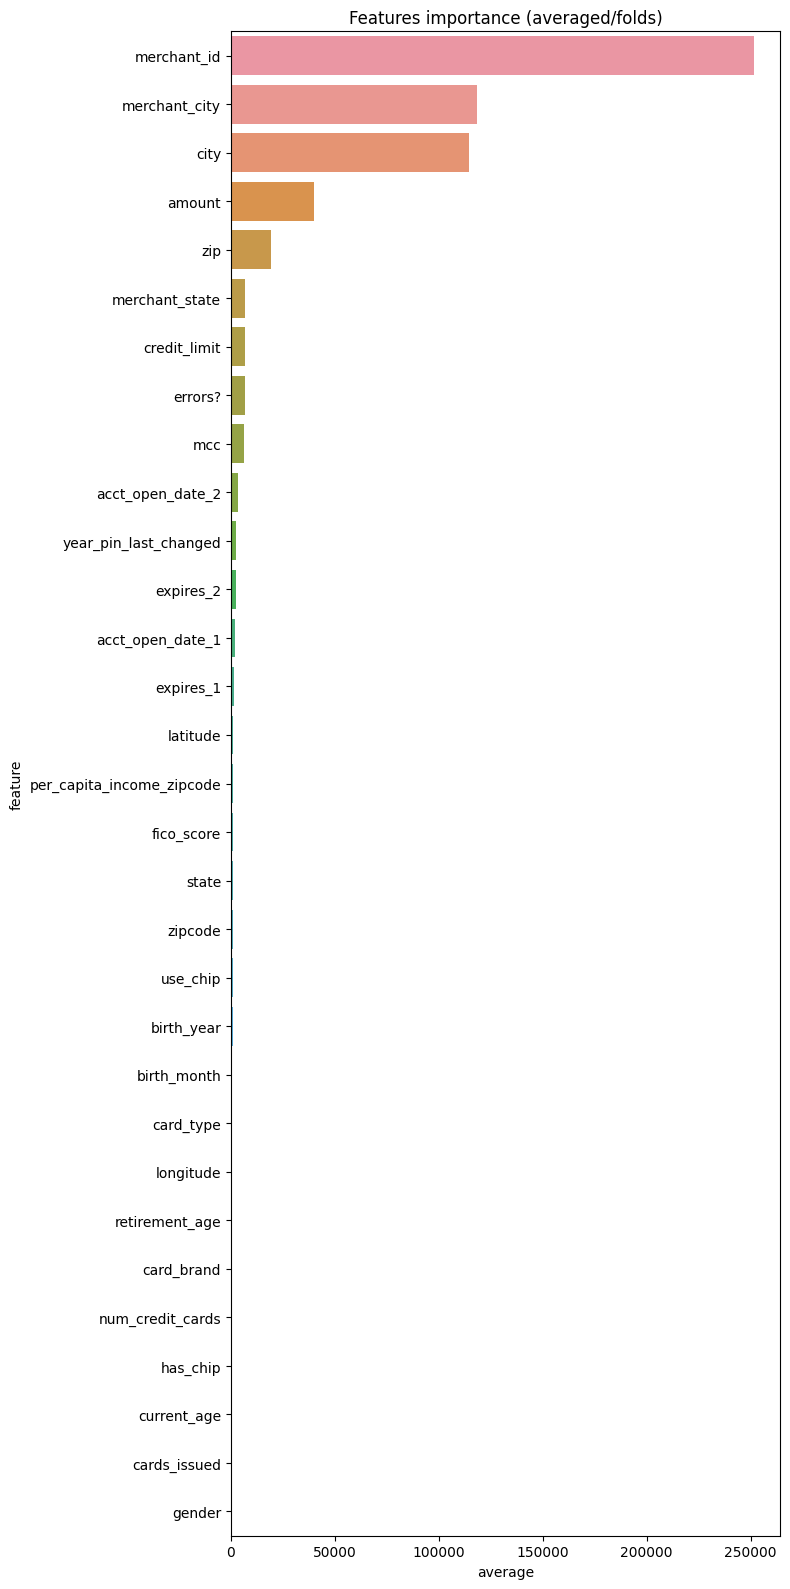

In [23]:
# ===================================================================
#  plot feature importance
# ===================================================================
feature_importance_df.fillna(value=0, inplace=True)
feature_importance_df["average"] = feature_importance_df.loc[:, 'importance_fold0':f'importance_fold{CFG.n_splits-1}'].mean(axis=1)
best_features = feature_importance_df[["feature", "average"]].groupby("feature", as_index=False).mean().sort_values(by="average", ascending=False).head(50)
plt.figure(figsize=(8, 16))
sns.barplot(x="average", y="feature", data=best_features)
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [25]:
# ===================================================================
#  prediction
# ===================================================================
test["pred"] = [1 if y > 0.356 else 0 for y in predictions]
print(test["pred"].min(), test["pred"].max())
test[["index", "pred"]].to_csv(CFG.save_dir+"exp001.csv", index=False, header=None)

0 1
